# Анализ выбора портфеля по коэффициенту Шарпа жадным алгоритмом

In [19]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Считываем данные

In [3]:
start = datetime.now()
data = pd.read_csv("Россия 37 Акций 2016-01.07.2019.txt")
data = np.array(data)
periods_in_data = data.shape[0]
print(periods_in_data)

881


In [4]:
print(data)

[[ 2.01601040e+07 -1.52180400e+00 -1.52155153e+00 ... -2.70986745e+00
   4.71380471e-01  1.11663653e+01]
 [ 2.01601050e+07  3.02138343e+00  1.12824001e+00 ...  3.70874962e+00
   2.37935657e+00  1.12647418e+01]
 [ 2.01601060e+07 -8.40336134e-02 -3.16966245e-01 ... -1.16771274e+00
  -5.72831424e-01  3.80116959e+00]
 ...
 [ 2.01906270e+07  4.01231688e-01  1.62874666e-01 ...  6.00200067e-01
   1.16510655e+00  1.03524229e+00]
 [ 2.01906280e+07 -1.39405204e+00 -4.96823352e-01 ... -4.97182632e-01
  -3.34678610e-01 -1.26444299e+00]
 [ 2.01907010e+07  1.38548539e+00  1.28785003e+00 ...  4.16389074e-01
  -6.81481481e-01  3.86398764e+00]]


In [22]:
data = np.delete(data, 0, axis = 1)
#data = np.delete(data, 0, axis = 1)  # Удалять дополительно второй столбец только в часовых котировках

stocks_to_portf_min = 5
stocks_to_portf_max = 6
stocks_to_portf_step = 1

sharp_period_min = 20
sharp_period_max = 320
sharp_period_step = 20

hold_period_min = 10       # Важна кратность диапазона end-start по hold(step)
hold_period_max = 190
hold_period_step = 10

sharp_period = 125
start_of_test_period = sharp_period_max
end_of_test_period = periods_in_data // hold_period_max * hold_period_max

mean_annual_profit_overal = []
P_L_overal = []
random_income_overal = []
random_portf_list = []
# Рассматриваем разное количество акций в портфеле по Кэф Шарпа
for stocks_to_portf in range(stocks_to_portf_min, stocks_to_portf_max, stocks_to_portf_step):
    # Рассматриваем разный период рассчета Кэф Шарпа.
    for sharp_period in range(sharp_period_min,sharp_period_max,sharp_period_step):
        print('sharp_period:', sharp_period)
        #Смотрим также результаты стратегии Купи и держи в те же периоды.
        P_L_by_hold = []
        mean_annual_profit_by_hold = []
        random_income_hold = []
        for hold in range(hold_period_min,hold_period_max,hold_period_step):
            print('hold:', hold)
            start_of_test_period = sharp_period_max # Должен быть больше чем sharp_period
            columns_count = data.shape[1] # число акций
            stocks_to_portf_list = []
            overal_results = []
            random_portf_list = []
            
            for i in range(start_of_test_period,end_of_test_period,hold):
            #for i in range(sharp_period,sharp_period+hold*10,hold):        # Пересчитываем через период hold коэфф Шарпа
                stocks_to_portf_list = []          
                counter = 1
                random_portf = np.mean(np.array(data[i-sharp_period:i,:]))
                random_array = np.array(data[i-sharp_period:i,:])
                random_portf_list.append(random_portf)
                for k in range(0, stocks_to_portf):
                    sharp_ratio_list = []
                    if counter == 1:                             # Выбираем первую акцию в портфель
                        for j in range(0, columns_count):
                            share_prices = np.array(data[i-sharp_period:i,j], dtype=float)
                            income = np.sum(share_prices)
                            std = np.std(share_prices)
                            if std > 0 and income > 0:
                                sharp_ratio = income/std
                            else:
                                sharp_ratio = 0
                            sharp_ratio_list.append(sharp_ratio)
                        
                        max_sharp_ratio = max(sharp_ratio_list)
                        indx_max_sharp_ratio = np.argmax(sharp_ratio_list)
                        comulative_income = np.array(data[i-sharp_period:i,indx_max_sharp_ratio], dtype=float)   # Инициализируем доход портфеля
                        stocks_to_portf_list.append(indx_max_sharp_ratio)
                        counter = counter + 1
                    else:
                        for j in range(0, columns_count):
                            if j in stocks_to_portf_list:    # Чтобы не включать акцию повторно
                                sharp_ratio_list.append(0)
                            else:
                                share_prices = np.array(data[i-sharp_period:i,j], dtype=float)
                                sub_sumpl_comulative_income = comulative_income + share_prices 
                                income = np.sum(sub_sumpl_comulative_income)
                                std = np.std(sub_sumpl_comulative_income)
                                if std > 0 and income > 0:
                                    sharp_ratio = income/std
                                else:
                                    sharp_ratio = 0
                                sharp_ratio_list.append(sharp_ratio)
                        
                        max_sharp_ratio = max(sharp_ratio_list)
                        indx_max_sharp_ratio = np.argmax(sharp_ratio_list)
                        comulative_income = comulative_income + np.array(data[i-sharp_period:i,indx_max_sharp_ratio], dtype=float)
                        stocks_to_portf_list.append(indx_max_sharp_ratio)
                        counter = counter + 1
                
                stocks_to_portf_list = np.array(stocks_to_portf_list)
                for j in range(0,stocks_to_portf):
                    if j == 0:
                        stock_ind = stocks_to_portf_list[j]
                        results = np.array(data[i:i+hold,stock_ind])#, dtype=float)
                    else:
                        stock_ind = stocks_to_portf_list[j]
                        results = results + np.array(data[i:i+hold,stock_ind])#, dtype=float)
                results = np.array(results)        
                overal_results.append(results)
            
            #overal_results = pd.DataFrame(overal_results)
            #print(overal_results)
            overal_results = np.array(overal_results)    
            
            
            # Анализируем результаты
            print(overal_results.shape)
            strings = overal_results.shape[0]
            rows  = overal_results.shape[1]
            
            mean_profit_list = []
            P_L_list = []
            
            for i in range(0, overal_results.shape[0]):
                profit = 0
                loss = 0
                for j in range(0, overal_results.shape[1]):
                    if overal_results[i][j] >= 0:
                        profit = profit + overal_results[i][j]
                    else:
                        loss = loss + overal_results[i][j]
                        
                mean_profit = (profit + loss)/stocks_to_portf
                P_L = -profit / loss
                mean_profit_list.append(mean_profit)
                P_L_list.append(P_L)
            
            mean_profit_list = np.array(mean_profit_list)
            P_L_list = np.array(P_L_list)
            random_portf_list = np.array(random_portf_list)
            
             
            #print(max_sharp_ratio, indx_max_sharp_ratio)
            #print(stocks_to_portf_list)
            #print(mean_profit_list)
            mean_annual_profit = mean_profit_list.mean()*(250 / hold)     # Менять когда час 2250 или День 250 
            P_L = P_L_list.mean()
            random_income = random_portf_list.mean() * 250              # Менять когда час 2250 или День 250
            
            mean_annual_profit_by_hold.append(mean_annual_profit)
            P_L_by_hold.append(P_L)
            random_income_hold.append(random_income)
            
            print('mean_annual_profit_by_hold:', mean_annual_profit_by_hold)
            #print('P_L_list.mean:', P_L)
            #print('random_portf_mean_profit:', random_income)
            
        
        mean_annual_profit_by_hold = np.array(mean_annual_profit_by_hold)
        P_L_by_hold = np.array(P_L_by_hold)
        random_income_hold = np.array(random_income_hold)
        
        mean_annual_profit_overal.append(mean_annual_profit_by_hold)
        print('mean_annual_profit_overal:', mean_annual_profit_overal)
        P_L_overal.append(P_L_by_hold)
        random_income_overal.append(random_income_hold)
        print('check')
            
#mean_annual_profit_overal = np.array(mean_annual_profit_overal)       
#P_L_overal = np.array(P_L_overal)
#random_income_overal = np.array(random_income_overal)  

hold_periods = range(hold_period_min, hold_period_max, hold_period_step)
sharp_periods = range(sharp_period_min, sharp_period_max, sharp_period_step)

mean_annual_profit_overal = pd.DataFrame(mean_annual_profit_overal)
P_L_overal = pd.DataFrame(P_L_overal)
random_income_overal = pd.DataFrame(random_income_overal)
                                        
mean_annual_profit_overal.columns = hold_periods
P_L_overal.columns = hold_periods
random_income_overal.columns = hold_periods

#mean_annual_profit_overal.insert(0, 'sharp_periods', sharp_periods)
#P_L_overal.insert(0, 'sharp_periods', sharp_periods)
#random_income_overal.insert(0, 'sharp_periods', sharp_periods)

print(mean_annual_profit_overal)
print(P_L_overal)
print(random_income_overal)

finish = datetime.now()
time_consumed = finish - start
print('start:', start)
print('finish:', finish)
print('time_consumed:', time_consumed)

#random_max_list = []
#random_min_list = []
#for i in range(0,random_array.shape[0]):
#    random_max_list.append(np.max(random_array[i,:]))
#    random_min_list.append(np.min(random_array[i,:]))
#
#print('random_max_list:', random_max_list)
#print('random_min_list:', random_min_list)

sharp_period: 20
hold: 10
(44, 10)
mean_annual_profit_by_hold: [-6.973556616280225]
hold: 20
(22, 20)
mean_annual_profit_by_hold: [-6.973556616280225, 4.182420234583496]
hold: 30
(15, 30)
mean_annual_profit_by_hold: [-6.973556616280225, 4.182420234583496, 9.965925580892154]
hold: 40
(11, 40)
mean_annual_profit_by_hold: [-6.973556616280225, 4.182420234583496, 9.965925580892154, -2.2851847085276056]
hold: 50
(9, 50)
mean_annual_profit_by_hold: [-6.973556616280225, 4.182420234583496, 9.965925580892154, -2.2851847085276056, 6.804499063897849]
hold: 60
(8, 60)
mean_annual_profit_by_hold: [-6.973556616280225, 4.182420234583496, 9.965925580892154, -2.2851847085276056, 6.804499063897849, 9.90264657731005]
hold: 70
(7, 70)
mean_annual_profit_by_hold: [-6.973556616280225, 4.182420234583496, 9.965925580892154, -2.2851847085276056, 6.804499063897849, 9.90264657731005, 10.91720227206978]
hold: 80
(6, 80)
mean_annual_profit_by_hold: [-6.973556616280225, 4.182420234583496, 9.965925580892154, -2.28518

(44, 10)
mean_annual_profit_by_hold: [18.400881072435393]
hold: 20
(22, 20)
mean_annual_profit_by_hold: [18.400881072435393, 21.140129854478516]
hold: 30
(15, 30)
mean_annual_profit_by_hold: [18.400881072435393, 21.140129854478516, 18.421926795450013]
hold: 40
(11, 40)
mean_annual_profit_by_hold: [18.400881072435393, 21.140129854478516, 18.421926795450013, 14.736504197984706]
hold: 50
(9, 50)
mean_annual_profit_by_hold: [18.400881072435393, 21.140129854478516, 18.421926795450013, 14.736504197984706, 12.237472758031]
hold: 60
(8, 60)
mean_annual_profit_by_hold: [18.400881072435393, 21.140129854478516, 18.421926795450013, 14.736504197984706, 12.237472758031, 19.33686144954979]
hold: 70
(7, 70)
mean_annual_profit_by_hold: [18.400881072435393, 21.140129854478516, 18.421926795450013, 14.736504197984706, 12.237472758031, 19.33686144954979, 14.70203819456736]
hold: 80
(6, 80)
mean_annual_profit_by_hold: [18.400881072435393, 21.140129854478516, 18.421926795450013, 14.736504197984706, 12.237472

(3, 180)
mean_annual_profit_by_hold: [12.56673601613465, 16.233533284717485, 16.895154677059526, 11.133947509541473, 5.747457820156047, 18.936783836519904, 17.95283096685329, 12.971218370637407, 18.680519163498357, 6.273389916672366, 19.54415595975667, 15.596766377631498, 20.851478904570097, 18.216663651020067, 12.639912731499034, 13.035813803410564, 12.877263929634445, 15.704568282739578]
mean_annual_profit_overal: [array([-6.97355662,  4.18242023,  9.96592558, -2.28518471,  6.80449906,
        9.90264658, 10.91720227,  6.06917832,  6.20031729, 11.64266985,
       10.9667017 ,  5.31098705, 18.85379582, 13.34454861,  6.14142858,
        3.94519343,  4.68750728,  3.24250069]), array([14.07410532, 16.28368263, 17.29781573,  8.90282499,  9.67711008,
       11.43992599, 20.4147521 , 13.73337324, 12.99735611, 15.32007599,
       17.8996058 ,  7.97269676, 17.84206343, 19.82662924, 17.36454073,
       13.59089237, 12.99526469, 12.25439031]), array([18.40088107, 21.14012985, 18.4219268 , 14.73

(4, 110)
mean_annual_profit_by_hold: [14.566007832166337, 16.52186772093573, 17.475685095841506, 12.221011429573169, 12.52146080247109, 18.568825194635707, 19.058520480598997, 10.45849012712682, 11.465262915165477, 15.915132009069719, 15.427122412634324]
hold: 120
(4, 120)
mean_annual_profit_by_hold: [14.566007832166337, 16.52186772093573, 17.475685095841506, 12.221011429573169, 12.52146080247109, 18.568825194635707, 19.058520480598997, 10.45849012712682, 11.465262915165477, 15.915132009069719, 15.427122412634324, -2.009009895306277]
hold: 130
(4, 130)
mean_annual_profit_by_hold: [14.566007832166337, 16.52186772093573, 17.475685095841506, 12.221011429573169, 12.52146080247109, 18.568825194635707, 19.058520480598997, 10.45849012712682, 11.465262915165477, 15.915132009069719, 15.427122412634324, -2.009009895306277, 7.3032951508940736]
hold: 140
(4, 140)
mean_annual_profit_by_hold: [14.566007832166337, 16.52186772093573, 17.475685095841506, 12.221011429573169, 12.52146080247109, 18.568825

(44, 10)
mean_annual_profit_by_hold: [20.77261391897351]
hold: 20
(22, 20)
mean_annual_profit_by_hold: [20.77261391897351, 21.896585671224138]
hold: 30
(15, 30)
mean_annual_profit_by_hold: [20.77261391897351, 21.896585671224138, 26.628679253509663]
hold: 40
(11, 40)
mean_annual_profit_by_hold: [20.77261391897351, 21.896585671224138, 26.628679253509663, 19.262516737084006]
hold: 50
(9, 50)
mean_annual_profit_by_hold: [20.77261391897351, 21.896585671224138, 26.628679253509663, 19.262516737084006, 16.838551055326874]
hold: 60
(8, 60)
mean_annual_profit_by_hold: [20.77261391897351, 21.896585671224138, 26.628679253509663, 19.262516737084006, 16.838551055326874, 21.855236130574518]
hold: 70
(7, 70)
mean_annual_profit_by_hold: [20.77261391897351, 21.896585671224138, 26.628679253509663, 19.262516737084006, 16.838551055326874, 21.855236130574518, 16.167249535587885]
hold: 80
(6, 80)
mean_annual_profit_by_hold: [20.77261391897351, 21.896585671224138, 26.628679253509663, 19.262516737084006, 16.83

(4, 130)
mean_annual_profit_by_hold: [18.470550160470385, 20.34918960984304, 25.197548256409572, 19.757448473466265, 18.90237659238182, 21.340805141134325, 19.215174619886458, 16.160469962412197, 27.368085087729916, 18.25190444313061, 17.30397372097977, 12.697012636542786, 19.87353078411025]
hold: 140
(4, 140)
mean_annual_profit_by_hold: [18.470550160470385, 20.34918960984304, 25.197548256409572, 19.757448473466265, 18.90237659238182, 21.340805141134325, 19.215174619886458, 16.160469962412197, 27.368085087729916, 18.25190444313061, 17.30397372097977, 12.697012636542786, 19.87353078411025, 19.30087898918742]
hold: 150
(3, 150)
mean_annual_profit_by_hold: [18.470550160470385, 20.34918960984304, 25.197548256409572, 19.757448473466265, 18.90237659238182, 21.340805141134325, 19.215174619886458, 16.160469962412197, 27.368085087729916, 18.25190444313061, 17.30397372097977, 12.697012636542786, 19.87353078411025, 19.30087898918742, 23.5151719786442]
hold: 160
(3, 160)
mean_annual_profit_by_hold

(44, 10)
mean_annual_profit_by_hold: [12.472683084078948]
hold: 20
(22, 20)
mean_annual_profit_by_hold: [12.472683084078948, 11.743361142899236]
hold: 30
(15, 30)
mean_annual_profit_by_hold: [12.472683084078948, 11.743361142899236, 16.83947043790109]
hold: 40
(11, 40)
mean_annual_profit_by_hold: [12.472683084078948, 11.743361142899236, 16.83947043790109, 11.037501006971526]
hold: 50
(9, 50)
mean_annual_profit_by_hold: [12.472683084078948, 11.743361142899236, 16.83947043790109, 11.037501006971526, 12.038843766182012]
hold: 60
(8, 60)
mean_annual_profit_by_hold: [12.472683084078948, 11.743361142899236, 16.83947043790109, 11.037501006971526, 12.038843766182012, 13.954313547119913]
hold: 70
(7, 70)
mean_annual_profit_by_hold: [12.472683084078948, 11.743361142899236, 16.83947043790109, 11.037501006971526, 12.038843766182012, 13.954313547119913, 13.304781833022563]
hold: 80
(6, 80)
mean_annual_profit_by_hold: [12.472683084078948, 11.743361142899236, 16.83947043790109, 11.037501006971526, 12.

(4, 110)
mean_annual_profit_by_hold: [11.869537124881118, 15.071818588328878, 19.237720529512984, 12.50876867004968, 12.080095773124812, 17.119822119641096, 10.712189485635262, 11.211619468271554, 16.714439601707678, 20.467828276737457, 16.87529984373937]
hold: 120
(4, 120)
mean_annual_profit_by_hold: [11.869537124881118, 15.071818588328878, 19.237720529512984, 12.50876867004968, 12.080095773124812, 17.119822119641096, 10.712189485635262, 11.211619468271554, 16.714439601707678, 20.467828276737457, 16.87529984373937, 9.070613680032947]
hold: 130
(4, 130)
mean_annual_profit_by_hold: [11.869537124881118, 15.071818588328878, 19.237720529512984, 12.50876867004968, 12.080095773124812, 17.119822119641096, 10.712189485635262, 11.211619468271554, 16.714439601707678, 20.467828276737457, 16.87529984373937, 9.070613680032947, 12.001916583894989]
hold: 140
(4, 140)
mean_annual_profit_by_hold: [11.869537124881118, 15.071818588328878, 19.237720529512984, 12.50876867004968, 12.080095773124812, 17.1198

(3, 180)
mean_annual_profit_by_hold: [12.247992895588066, 13.940514766274653, 14.459909775033026, 9.812592690815096, 10.786584763559715, 9.460561437636146, 11.425566910381061, 11.572046922425649, 14.19202988943115, 13.661787850659737, 19.63532136463634, 10.59095340791322, 12.038961348047238, 11.124316137144028, 10.441796472696774, 14.673479747693444, 8.958283331407046, 10.58919803339182]
mean_annual_profit_overal: [array([-6.97355662,  4.18242023,  9.96592558, -2.28518471,  6.80449906,
        9.90264658, 10.91720227,  6.06917832,  6.20031729, 11.64266985,
       10.9667017 ,  5.31098705, 18.85379582, 13.34454861,  6.14142858,
        3.94519343,  4.68750728,  3.24250069]), array([14.07410532, 16.28368263, 17.29781573,  8.90282499,  9.67711008,
       11.43992599, 20.4147521 , 13.73337324, 12.99735611, 15.32007599,
       17.8996058 ,  7.97269676, 17.84206343, 19.82662924, 17.36454073,
       13.59089237, 12.99526469, 12.25439031]), array([18.40088107, 21.14012985, 18.4219268 , 14.7365

(44, 10)
mean_annual_profit_by_hold: [5.020185574907133]
hold: 20
(22, 20)
mean_annual_profit_by_hold: [5.020185574907133, 7.6136221576073195]
hold: 30
(15, 30)
mean_annual_profit_by_hold: [5.020185574907133, 7.6136221576073195, 15.337949098188895]
hold: 40
(11, 40)
mean_annual_profit_by_hold: [5.020185574907133, 7.6136221576073195, 15.337949098188895, 1.924809844614947]
hold: 50
(9, 50)
mean_annual_profit_by_hold: [5.020185574907133, 7.6136221576073195, 15.337949098188895, 1.924809844614947, 11.136893276388522]
hold: 60
(8, 60)
mean_annual_profit_by_hold: [5.020185574907133, 7.6136221576073195, 15.337949098188895, 1.924809844614947, 11.136893276388522, 10.97790708412568]
hold: 70
(7, 70)
mean_annual_profit_by_hold: [5.020185574907133, 7.6136221576073195, 15.337949098188895, 1.924809844614947, 11.136893276388522, 10.97790708412568, 13.009255161287]
hold: 80
(6, 80)
mean_annual_profit_by_hold: [5.020185574907133, 7.6136221576073195, 15.337949098188895, 1.924809844614947, 11.136893276388

<AxesSubplot:>

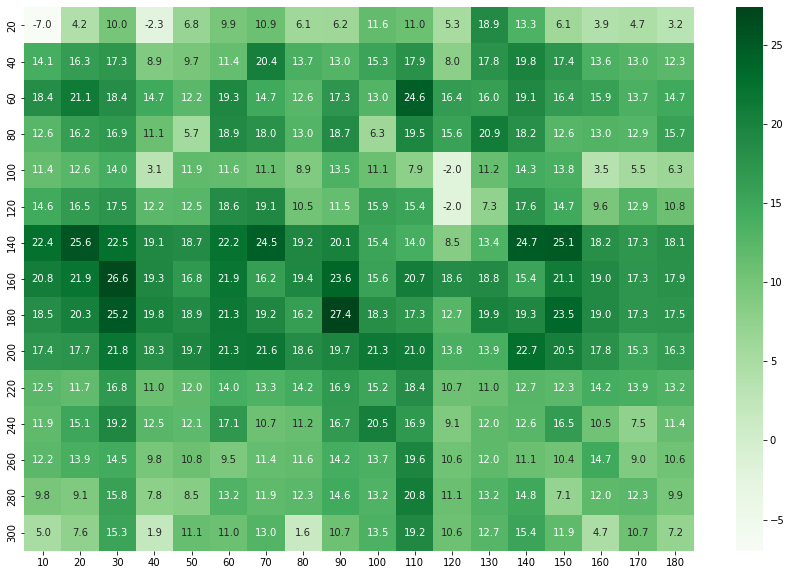

In [23]:
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(mean_annual_profit_overal, annot=True, fmt=".1f", xticklabels = True,
            yticklabels = sharp_periods, cmap="Greens")

<AxesSubplot:>

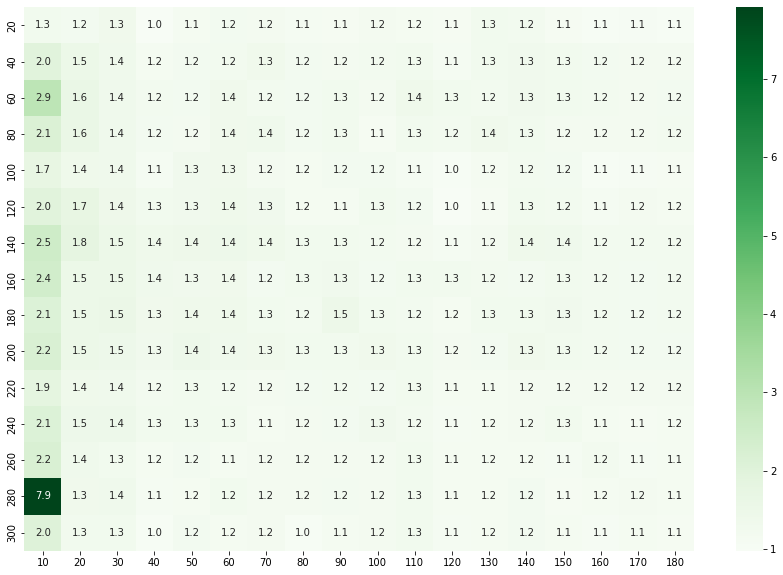

In [24]:
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(P_L_overal, annot=True, fmt=".1f", xticklabels = True,
            yticklabels = sharp_periods, cmap="Greens")

<AxesSubplot:>

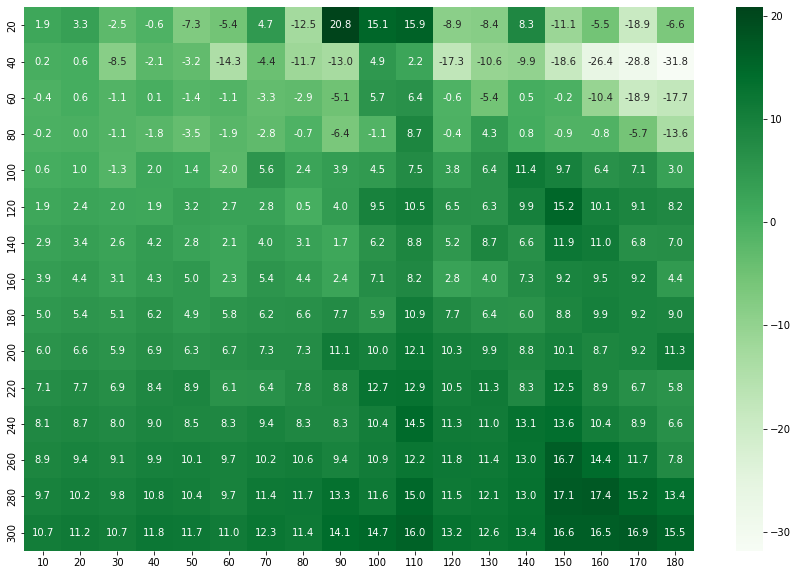

In [25]:
plt.rcParams['figure.figsize'] = 15, 10
sns.heatmap(random_income_overal, annot=True, fmt=".1f", xticklabels = True,
            yticklabels = sharp_periods, cmap="Greens")